In [2]:
# 基礎
import pandas as pd
import numpy as np
import math
import json
import os
import jieba  ## 斷字
# jieba.set_dictionary('dict.txt')
stopwords = [ line.rstrip() for line in open('stop_words.txt' , encoding='utf8') ] ## 這個中文停用字典可以自己找

# 視覺化
import matplotlib.pyplot as plt  ## python最常見的繪圖工具
import matplotlib
zhfont1 = matplotlib.font_manager.FontProperties(fname='simsun.ttf')  ## plt中文字
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA  ## 降維視覺化常用工具
from pylab import rcParams  ## 調整畫布比例

# 訓練模型
from sklearn.model_selection import train_test_split  ## 切分鍊與測試資料集
from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.svm import SVC  ## SVM
from  xgboost import XGBClassifier  ## xgboost
import xgboost

# 從新竹社會局常見問答集爬取
def getdata():
    with open('RawData.json', 'r', encoding='utf8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

In [3]:
df_train = getdata()
print("Rows=",len(df_train))
df_train.head()

Rows= 327


,ans,cat,id,question
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？


In [4]:
# 斷字
# 這個地方斷字模式的選擇非常重要，因為中文斷字採用精準模式可以方便人們閱讀，
# 但是如果要讓機器去認識相關性，最好可以讓句子當中所有可能的資訊都被包含進去，而採用全斷詞模式可以得到所有的斷字可能，如此一來，
# 便能增加斷詞後句子的資訊含量。這部分之所以會檢查出來之後，
# 下面的PCA圖(比較下面)也可以明顯看出，每個句字的資訊含量增多了之後，有平滑資料的功能

In [5]:
def preprocess(question):
#     words = list(jieba.cut(question)) ## 精準模式
    words = list(jieba.cut(question, cut_all=True)) ## 全斷詞模式
    return words
# 將處理玩資料放入df_train['words'] apply()=>call() 呼叫方法的應用
df_train['words'] = df_train['question'].apply(preprocess)
df_train.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.842 seconds.
Prefix dict has been built succesfully.


,ans,cat,id,question,words
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應, 於, 何, 時, 申, 請, 育, 兒, 津, 貼, , ]"
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應, 於, 何, 時, 申, 請, 育, 兒, 津, 貼, , ]"
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?,"[育, 兒, 津, 貼, 申, 請, 應, 備, 文件, 為, 何, , ]"
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助,"[若, 民, 眾, 夫妻, 雙, 方, 均, 失, 業, , , 是否, 可, 申, 請, ..."
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？,"[育, 兒, 津, 貼, 補, 助, 對, 象, 為, 何, , ]"


In [6]:
# 準備把文字類別轉換成數字類別
# 為了訓練需要，將類別轉化為數字類別(1~11類)
cat_mapping = {}
for num, cat in enumerate(list(set(df_train['cat']))):
    cat_mapping[cat] = num
    
# 預測時，要將預測出的結果翻譯為原先的類別所使用
inversed_cat_mapping = {}
for cat, idx in cat_mapping.items():
    inversed_cat_mapping[idx] = cat

print(cat_mapping)
print(inversed_cat_mapping)

# {'國民年金': 1, '社區發展服務': 2, '社工專業服務': 11, '兒童少年及家庭福利': 3, '身心障礙者福利': 4, '家庭暴力及性侵害防治服務': 8, '婦女福利': 6, '幼兒福利及托育服務': 7, '人民團體及合作社場服務': 9, '社會救助': 5, '老人福利': 10, '志願服務': 0}
# {0: '志願服務', 1: '國民年金', 2: '社區發展服務', 3: '兒童少年及家庭福利', 4: '身心障礙者福利', 5: '社會救助', 6: '婦女福利', 7: '幼兒福利及托育服務', 8: '家庭暴力及性侵害防治服務', 9: '人民團體及合作社場服務', 10: '老人福利', 11: '社工專業服務'}

{'家庭暴力及性侵害防治服務': 0, '志願服務': 1, '社區發展服務': 2, '社工專業服務': 3, '婦女福利': 4, '身心障礙者福利': 5, '人民團體及合作社場服務': 6, '國民年金': 7, '社會救助': 8, '幼兒福利及托育服務': 9, '兒童少年及家庭福利': 10, '老人福利': 11}
{0: '家庭暴力及性侵害防治服務', 1: '志願服務', 2: '社區發展服務', 3: '社工專業服務', 4: '婦女福利', 5: '身心障礙者福利', 6: '人民團體及合作社場服務', 7: '國民年金', 8: '社會救助', 9: '幼兒福利及托育服務', 10: '兒童少年及家庭福利', 11: '老人福利'}


In [7]:
print('Preprocess Length = ', len(df_train))

addedrow = []
for key, value in cat_mapping.items():
    row = {}
    words = list(jieba.cut(key, cut_all=False))
    row['words'] = words
    
    row = {'ans': None,
            'cat': key,
            'cat_num': value,
            'id': None,
            'question': key,
            'words':words
          }
    addedrow.append(row)
addeddf = pd.DataFrame(addedrow)
df_train = pd.concat([df_train, addeddf])
print('Processed Length = ', len(df_train))

Preprocess Length =  327
Processed Length =  339


D:\Anacond\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



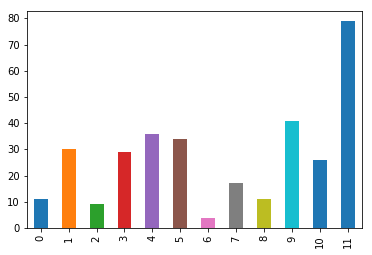

A 人民團體及合作社場服務 11
B 兒童少年及家庭福利 30
C 國民年金 9
D 婦女福利 29
E 家庭暴力及性侵害防治服務 36
F 幼兒福利及托育服務 34
G 志願服務 4
H 社區發展服務 17
I 社工專業服務 11
J 社會救助 41
K 老人福利 26
L 身心障礙者福利 79


In [8]:
# 訓練出來的類別分配比例，與訓練資料集內部的類別分配比例會相同，
# 因此如果未來使用者詢問的問題的比例與這個比例不同，將很有可能導致預測的失準，
# 因此這部分要特別注意。如果知道真實的使用者詢問比例

main_series = df_train.groupby('cat').count()['ans']
main_series.plot(kind='bar', use_index=False)
# 存起來的modules壞了
# plt.savefig(os.path.join('pic', 'nums_of_queries_each_cat'))
plt.show()

for i in range(len(list(main_series.index))):
    label = 'ABCDEFGHIJKLMNOPQRSTU'
    print(label[i], main_series.index[i], list(main_series)[i])

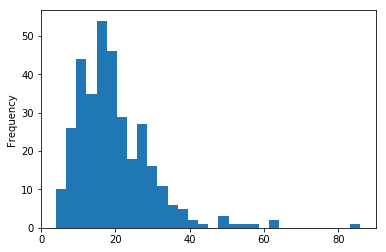

In [9]:
df_train['question'].apply(len).plot(kind='hist', bins=30)
plt.show()

In [10]:
# 每個類別常出現的字
from wordcloud import WordCloud
from collections import Counter

freqs = []
for cat in list(set(df_train['cat'])):
    words_Li = list(df_train[df_train['cat'] == cat]['words'])
    total_words_in_cat = []
    for words in words_Li:
        total_words_in_cat.extend(words)
    freq = Counter(total_words_in_cat)
    print(cat)
#     wordcloud = WordCloud(font_path="simsun.ttf")
    wordcloud.generate_from_frequencies(frequencies=freq)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(cat, fontproperties=zhfont1)
    plt.show()

家庭暴力及性侵害防治服務


NameError: name 'wordcloud' is not defined

In [ ]:
# 準備排序的文字list(keywordindex)
total_li = []
for li in list(df_train['words']):
    total_li += li
vectorterms = list(set(total_li))

## 轉化每個問題變成向量
def vectorize(words):
    self_main_list = [0] * len(vectorterms)
    for term in words:
        if term in vectorterms:  ## 測試資料集當中的字不一訂有出現在訓練資料集中
            idx = vectorterms.index(term)
            self_main_list[idx] += 1
    return np.array(self_main_list)

X = np.concatenate(df_train['words'].apply(vectorize).values).reshape(-1, len(vectorterms))
Y = df_train['cat'].apply(cat_mapping.get)
print(X.shape)
print(Y.shape)

In [ ]:
# 查看訓練資料的資料分布
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA_")
ax.set_xlabel("1st ")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd ")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd ")
ax.w_zaxis.set_ticklabels([])
# 存起來的modules壞掉了
# plt.savefig(os.path.join('pic', 'PCA_cutall'))
plt.show()

In [ ]:
# Finally, we split some of the data off for validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=123)

print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

In [ ]:
# 定義函式，輸入分類器，輸出準確率
def get_accuracy(clf, *args):
    if args:
        clf = clf(kernel=args[0])  ## SVM在這邊用Llinear比較準
    else:
        clf = clf()
    clf = clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    return (str(sum(Y_valid == y_pred)/Y_valid.shape[0]))

print('KNN: ', get_accuracy(KNeighborsClassifier))
print('SVM_rbf: ', get_accuracy(SVC))
print('SVM_linear: ', get_accuracy(SVC, 'linear'))
print('XGB: ', get_accuracy(XGBClassifier))

In [ ]:
params = {}
params['objective'] = 'multi:softmax'  ## 因為是多個類別，這邊跟前面兩個類別的使用不太一樣
params['eta'] = 0.1
params['max_depth'] = 3
params['silent'] = 1
params['nthread'] = 4
params['num_class'] = len(set(Y))  ## 多個類別，記得要告訴她有幾個類別

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)

In [ ]:
y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy_valid: ", str(sum(Y_valid == y_pred)/Y_valid.shape[0]))
y_pred = bst.predict(xgboost.DMatrix(X))
print("Accuracy_all: ", str(sum(Y == y_pred)/Y.shape[0]))
# 準確度高達86%

In [ ]:
# This is crawled from 台北社會局常見問答集
# with open('Taipei_Society_Affiar_QA', 'r', encoding='utf8') as f:
#     testing_questions = eval(f.read())
#     testing_questions = np.random.choice(testing_questions, size=len(testing_questions))
df_test=pd.read_excel('my data path')
# df_test = pd.DataFrame(testing_questions, columns=['question'])
# df_test.head()

In [ ]:
def predict(question):  ## 定義預測函數
    words = preprocess(question)
    vector = vectorize(words)
    cat_num = bst.predict(xgboost.DMatrix(vector.reshape(1, -1)))
    return inversed_cat_mapping.get(cat_num[0])
df_test['cat_pred'] = df_test['Submit'].apply(predict)
df_test[['Submit', 'cat_pred']]

In [ ]:
# 檢視錯誤預測
df_train_error = df_train[['question', 'cat']]
df_train_error['cat_pred'] = df_train_error['question'].apply(predict)
df_train_error.loc[df_train_error['cat'] != df_train_error['cat_pred'], ['question', 'cat', 'cat_pred']]

In [46]:
query = input("請輸入你的問題?\n")
predict(query)

請輸入你的問題?
中華民國台灣


'社工專業服務'